In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
data = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
data = data.sample(frac=1, random_state=100)
data = data.reset_index(drop=True)
data.head()

,image_id,label
0,2747068344.jpg,2
1,2534559127.jpg,3
2,3918476365.jpg,3
3,2779467880.jpg,2
4,55220429.jpg,3


In [4]:
extra_path = "../input/cassava-leaf-disease-classification/train_images/"
data["image_id"] = extra_path + data["image_id"]

In [5]:
data.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,2
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,3
3,../input/cassava-leaf-disease-classification/t...,2
4,../input/cassava-leaf-disease-classification/t...,3


In [6]:
type(data["label"][0])

numpy.int64

In [7]:
# converting numpy.int --> str for categorization
convert_dict = { 'label': 'string'} 
data = data.astype(convert_dict)

In [8]:
type(data["label"][0])

str

In [9]:
data.head()

,image_id,label
0,../input/cassava-leaf-disease-classification/t...,2
1,../input/cassava-leaf-disease-classification/t...,3
2,../input/cassava-leaf-disease-classification/t...,3
3,../input/cassava-leaf-disease-classification/t...,2
4,../input/cassava-leaf-disease-classification/t...,3


In [10]:
#datagen=ImageDataGenerator(rescale=1./255)

In [11]:
train_aug_gen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=25,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

#train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_df = data[:int(0.8*len(data))]
valid_df = data[int(0.8*len(data)):]

In [13]:
train_generator=train_aug_gen.flow_from_dataframe(dataframe=train_df, 
                                                  x_col="image_id", y_col="label",
                                                  class_mode="categorical", 
                                                  target_size=(224,224), batch_size=32,
                                                  shuffle=True)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=valid_df, 
                                                  x_col="image_id", y_col="label",
                                                  class_mode="categorical", 
                                                  target_size=(224,224), batch_size=32)

Found 17117 validated image filenames belonging to 5 classes.
Found 4280 validated image filenames belonging to 5 classes.


In [14]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
EPOCHS = 30

In [15]:
import tensorflow_addons as tfa

In [16]:
def fully_connected_model():
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
    base_model.trainable = True #it is false by default

    # Add custom layers
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x = tf.keras.layers.Dropout(0.75)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 
    x = tf.keras.layers.Dropout(0.75)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 
    x = tf.keras.layers.Dropout(0.75)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 
    x = tf.keras.layers.Dropout(0.75)(x)
    x = tf.keras.layers.Dense(128,activation='relu')(x) #dense layer 
    x = tf.keras.layers.Dropout(0.75)(x)
    preds = tf.keras.layers.Dense(5,activation='softmax')(x) 

    model = tf.keras.Model(inputs=base_model.input,outputs=preds) 
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                                 decay_steps=100000, 
                                                                 decay_rate=0.9)
    #optimizer = tf.keras.optimizers.Adam()
    optimizer = tfa.optimizers.RectifiedAdam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
resnet_model = fully_connected_model()
resnet_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='./resnet_2.{epoch:02d}-{val_accuracy:.2f}.h5',
                                       monitor='val_accuracy', mode='max')
]

In [18]:
history2 = resnet_model.fit_generator(generator=train_generator,
                                      steps_per_epoch=STEP_SIZE_TRAIN, epochs=EPOCHS,
                                      validation_data=valid_generator,
                                      validation_steps=STEP_SIZE_VALID,
                                      verbose=1, shuffle=1, 
                                      callbacks=my_callbacks)

Epoch 1/10
534/534 [==============================] - 329s 616ms/step - loss: 1.0621 - accuracy: 0.5948 - val_loss: 1.3831 - val_accuracy: 0.6154
Epoch 2/10
534/534 [==============================] - 234s 438ms/step - loss: 0.8980 - accuracy: 0.6601 - val_loss: 1.1780 - val_accuracy: 0.5780
Epoch 3/10
534/534 [==============================] - 234s 438ms/step - loss: 0.8471 - accuracy: 0.6790 - val_loss: 1.0159 - val_accuracy: 0.6414
Epoch 4/10
534/534 [==============================] - 232s 435ms/step - loss: 0.8569 - accuracy: 0.6822 - val_loss: 1.2607 - val_accuracy: 0.6866
Epoch 5/10
534/534 [==============================] - 235s 440ms/step - loss: 0.7857 - accuracy: 0.7112 - val_loss: 1.4717 - val_accuracy: 0.4377
Epoch 6/10
534/534 [==============================] - 234s 439ms/step - loss: 0.7649 - accuracy: 0.7267 - val_loss: 0.9320 - val_accuracy: 0.6414
Epoch 7/10
534/534 [==============================] - 233s 437ms/step - loss: 0.7590 - accuracy: 0.7313 - val_loss: 2.1177 -

In [19]:
import matplotlib.pyplot as plt

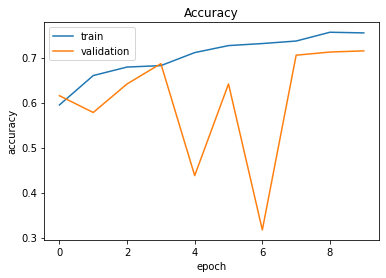

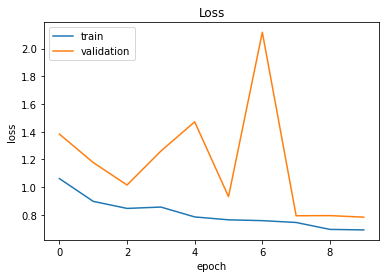

In [20]:
#  "Accuracy"
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Saving the model

1. Save model architecture in .json
2. Save model weights in .h5

In [21]:
# serialize model to JSON
model_json = resnet_model.to_json()
with open("Resnet_2.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
# serialize weights to HDF5
resnet_model.save_weights("Resnet_2.h5")
print("Saved model to disk")

Saved model to disk
